# AnaStarPhotometry

- creation date : 23 juin 2019
- author Sylvie Dagoret
- update : 26 juin 2019

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time


In [2]:
from astropy.table import Table,QTable

In [3]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(10,10)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Import Data

In [4]:
t = Table.read('processStarPhotometry.ecsv', format='ascii.ecsv')

In [5]:
t["airmass"].info.format = '%1.2f'  # for consistent table output
t["starmag"].info.format = '%2.3f'
t["bkgmag"].info.format = '%2.3f'
t["starmagerr"].info.format = '%1.3g'
t["bkgmagerr"].info.format = '%1.3g'
t["x0"].info.format = '%3.0f'
t["y0"].info.format = '%3.0f'

In [6]:
t[:5]

date,airmass,starmag,bkgmag,starmagerr,bkgmagerr,x0,y0,file
object,float64,float64,float64,float64,float64,float64,float64,str73
2019-02-15T22:55:50.730,1.55,-16.096,-13.366,0.000311,0.00105,417,90,T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits
2019-02-15T22:56:26.007,1.54,-16.095,-13.367,0.000312,0.00105,417,86,T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red_spectrum.fits
2019-02-15T22:57:01.284,1.54,-16.096,-13.370,0.000311,0.00105,417,87,T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red_spectrum.fits
2019-02-15T22:57:36.562,1.54,-16.039,-13.345,0.00032,0.00106,467,43,T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red_spectrum.fits
2019-02-15T22:58:11.838,1.53,-16.043,-13.328,0.000319,0.00107,464,43,T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red_spectrum.fits


In [7]:
t[0]

date,airmass,starmag,bkgmag,starmagerr,bkgmagerr,x0,y0,file
object,float64,float64,float64,float64,float64,float64,float64,str73
2019-02-15T22:55:50.730,1.55,-16.096,-13.366,0.000311,0.00105,417,90,T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red_spectrum.fits


In [8]:
Nobs=len(t)

## Convert in datetime

- necessary for plotting

In [9]:
all_datetime = [Time(d,format='isot', scale='utc').to_datetime()  for d in t["date"]]

## Make color pallet

In [10]:
Nobs = len(all_datetime)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=Nobs)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(Nobs), alpha=1)

In [11]:
len(all_colors)

347

# Filter bad data

In [12]:
badphotometrylist = np.array(
    [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
     82, 83, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
     123, 124, 125,
     187, 195, 202, 237, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
     272, 273,
     316, 317, 234, 326, 345])

In [13]:
t.remove_rows(badphotometrylist)

In [14]:
len(t)

261

In [15]:
new_all_colors = [ ]
new_all_datetime = []
for idx in np.arange(Nobs):
    if idx not in badphotometrylist:
        new_all_colors.append(all_colors[idx])
        new_all_datetime.append(all_datetime[idx])
new_all_colors=np.array(new_all_colors)

In [16]:
len(new_all_colors)

261

In [17]:
len(new_all_datetime)

261

# Plot Functions

In [18]:
#---------------------------------------------------------------------------------------------

def PlotXY(ifig,X,Y,XMIN=0,XMAX=2048,YMIN=0,YMAX=2048):
    """

    :param X:
    :param Y:
    :return:
    """

    fig = plt.figure(num=ifig, figsize=(10, 10))

    Nobs = len(X)

    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=Nobs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(Nobs), alpha=1)

    plt.scatter(X,Y, marker="o", c=all_colors)


    plt.grid(True, color="k")
    plt.xlabel(" X (pixel) ")
    plt.ylabel(" Y (pixel) ")
    plt.title("Star Trajectory")
    plt.xlim(XMIN,XMAX)
    plt.ylim(YMIN,YMAX)
    plt.show()

In [19]:
#---------------------------------------------------------------
def PlotStarmagBkgvsUTC(ifig,all_datetime, all_starmag,all_bkgmag,all_starmag_err,all_bkgmag_err,YMIN=0,YMAX=0):
    """

    :param ifig:
    :param all_airmass:
    :param all_datetime:
    :param all_flag:
    :return:
    """

    fig = plt.figure(num=ifig, figsize=(16, 8))

    Nobs = len(all_datetime)

    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=Nobs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(Nobs), alpha=1)




    myFmt = mdates.DateFormatter('%d-%H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

    #plt.scatter(all_datetime, all_airmass, marker="o", c=all_colors)
    plt.scatter(all_datetime, all_starmag, marker="o", c="red",label="star")
    plt.scatter(all_datetime, all_bkgmag, marker="o", c="blue",label="sky bkg")

    plt.errorbar(all_datetime, all_starmag, yerr=all_starmag_err, fmt='o', color="red", ecolor='grey')
    plt.errorbar(all_datetime, all_bkgmag, yerr=all_bkgmag_err, fmt='o', color="blue", ecolor='grey')


    #plt.plot([all_datetime[IDXMINREF], all_datetime[IDXMINREF]], [all_bkgmag.min(), all_bkgmag.max()], "g-")
    #plt.plot([all_datetime[IDXMAXREF], all_datetime[IDXMAXREF]], [all_bkgmag.min(), all_bkgmag.max()], "g-")

    #plt.plot([all_datetime[IDXMINREF], all_datetime[IDXMINREF]], [all_starmag.min(), all_starmag.max()], "g-")
    #plt.plot([all_datetime[IDXMAXREF], all_datetime[IDXMAXREF]], [all_starmag.min(), all_starmag.max()], "g-")

    myFmt = mdates.DateFormatter('%d-%H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.gcf().autofmt_xdate()

    plt.xlim(all_datetime[0], all_datetime[-1])
    
    if YMIN!=0 or YMAX!=0:
        plt.ylim(YMIN,YMAX)

    plt.grid(True, color="r")
    plt.xlabel("date (UTC)")
    plt.ylabel("Star/Bkg magnitude (mag)")
    plt.title("Star and Bkg magnitude vs date")
    plt.legend()

    plt.show()


In [20]:
#---------------------------------------------------------------
def PlotStarmagvsUTC(ifig,all_datetime, all_starmag,all_starmag_err,YMIN,YMAX):
    """

    :param ifig:
    :param all_airmass:
    :param all_datetime:
    :param all_flag:
    :return:
    """

    fig = plt.figure(num=ifig, figsize=(16, 8))

    Nobs = len(all_datetime)

    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=Nobs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(Nobs), alpha=1)


    myFmt = mdates.DateFormatter('%d-%H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

    #plt.errorbar(all_datetime, all_starmag, yerr=all_starmag_err, fmt='.', color="red", ecolor='grey')
    plt.scatter(all_datetime, all_starmag, marker="o", c=all_colors)


    #plt.plot([all_datetime[IDXMINREF], all_datetime[IDXMINREF]], [all_starmag.min(), all_starmag.max()], "g-")
    #plt.plot([all_datetime[IDXMAXREF], all_datetime[IDXMAXREF]], [all_starmag.min(), all_starmag.max()], "g-")


    myFmt = mdates.DateFormatter('%d-%H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.gcf().autofmt_xdate()

    plt.xlim(all_datetime[0], all_datetime[-1])
    if YMIN!=0 or YMAX!=0:
        plt.ylim(YMIN,YMAX)

    plt.grid(True, color="k")
    plt.xlabel("date (UTC)")
    plt.ylabel("Star magnitude (mag)")
    plt.title("Star magnitude vs date")
    #plt.legend()

    plt.show()

# Plot Figures

In [21]:
ifig=10000

## Trajectory of the star

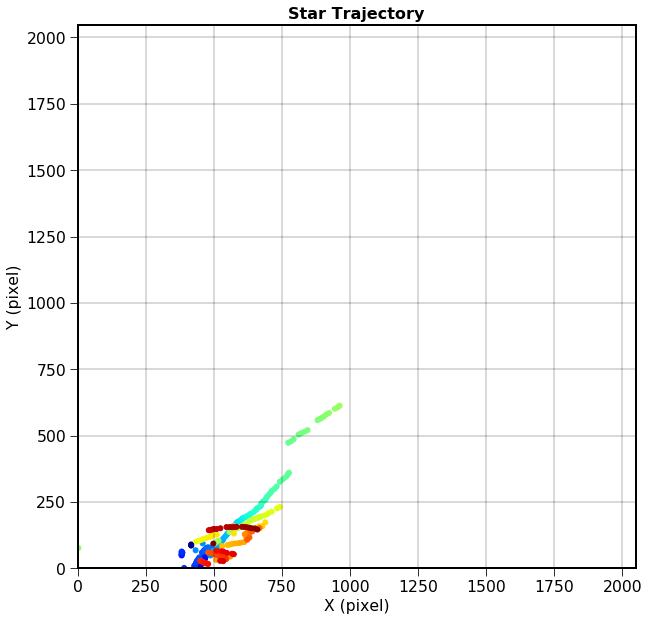

In [22]:
PlotXY(ifig,t["x0"],t["y0"])

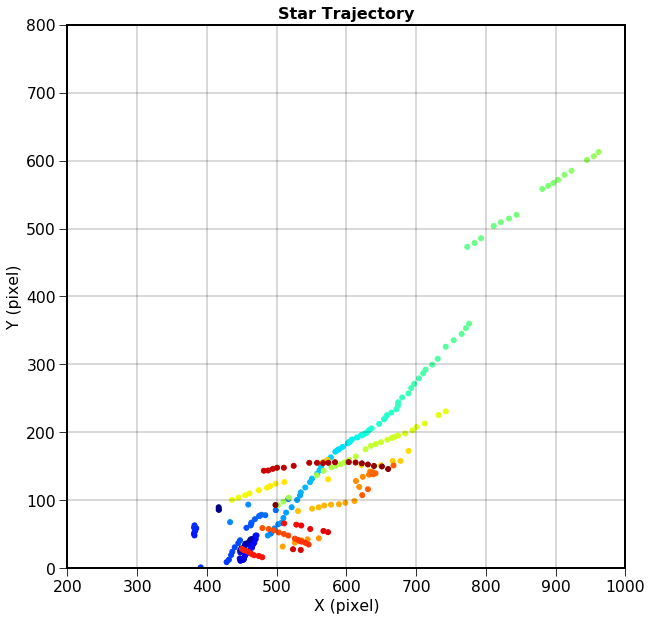

In [23]:
PlotXY(ifig,t["x0"],t["y0"],XMIN=200,XMAX=1000,YMIN=0,YMAX=800)

## Convert in datetime

In [24]:
#all_datetime = [Time(d,format='isot', scale='utc').to_datetime()  for d in t["date"]]

In [25]:
len(t)

261

In [26]:
len(new_all_datetime)

261

## Plot Star magnitude

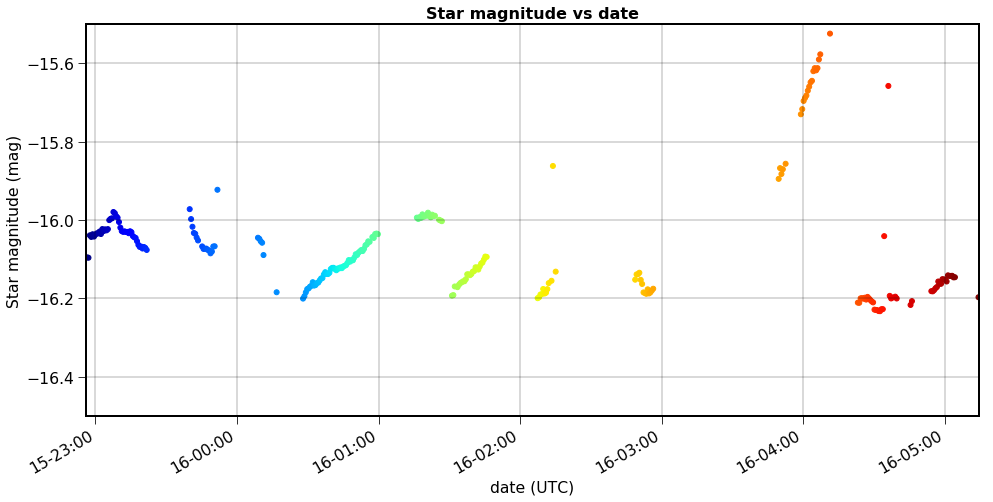

In [27]:
PlotStarmagvsUTC(ifig,new_all_datetime,t["starmag"],t["starmagerr"],YMIN=-16.5,YMAX=-15.5)

## Star and Background magnitude

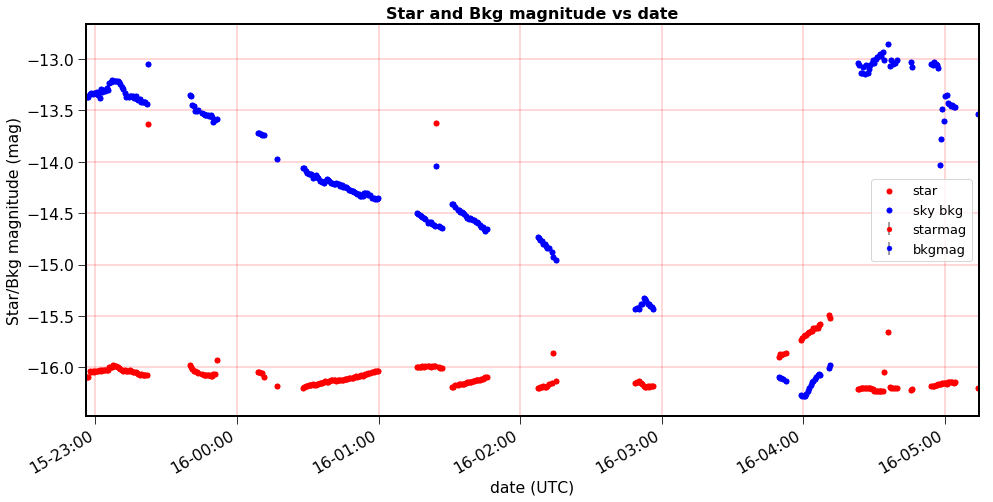

In [28]:
PlotStarmagBkgvsUTC(ifig,new_all_datetime,t["starmag"],t["bkgmag"],t["starmagerr"],t["bkgmagerr"])

## Star Magnitude vs X

Text(0.5, 1.0, 'Star magnitude vs X')

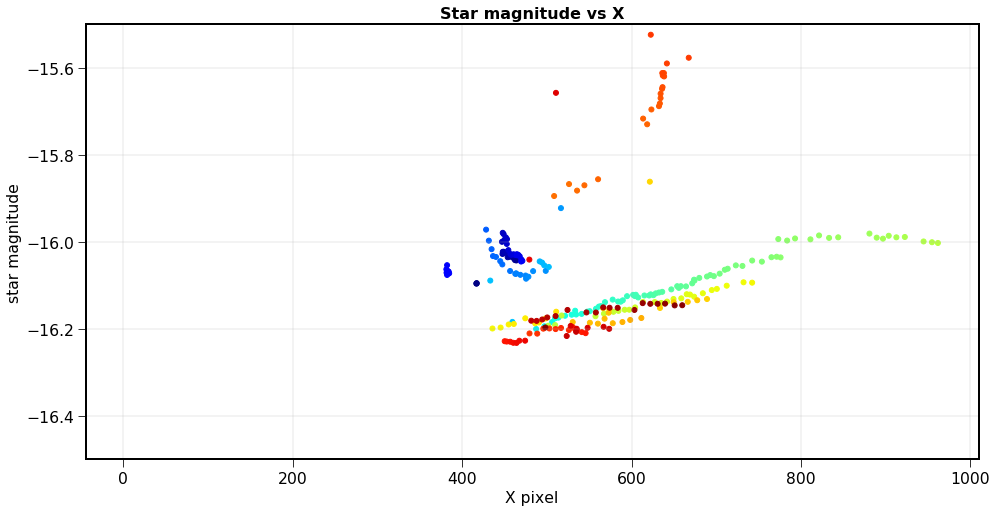

In [29]:
plt.figure(figsize=(16,8))
plt.scatter(t["x0"],t["starmag"],marker="o",c=new_all_colors)
plt.grid()
#plt.ylim(-16.25,-15.9)
plt.xlabel("X pixel")
plt.ylabel("star magnitude")
plt.ylim(-16.5,-15.5)
plt.title("Star magnitude vs X")

## Star Magnitude vs Y

Text(0.5, 1.0, 'Star magnitude vs Y')

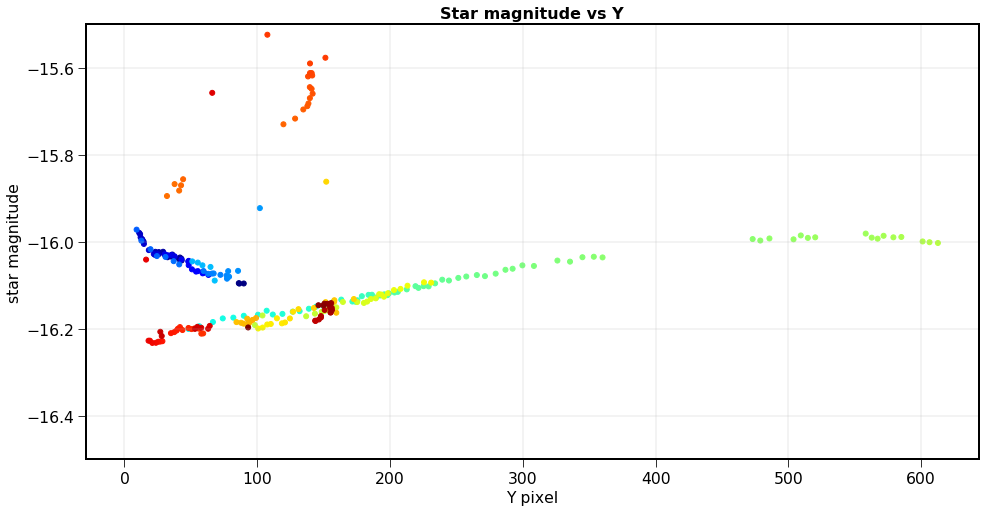

In [30]:
plt.figure(figsize=(16,8))
plt.scatter(t["y0"],t["starmag"],marker="o",c=new_all_colors)
plt.grid()
#plt.ylim(-16.25,-15.9)
plt.xlabel("Y pixel")
plt.ylabel("star magnitude")
plt.ylim(-16.5,-15.5)
plt.title("Star magnitude vs Y")

Text(0.5, 1.0, 'Star magnitude vs $D=\\sqrt{x^2+y^2}$ from Hologram center')

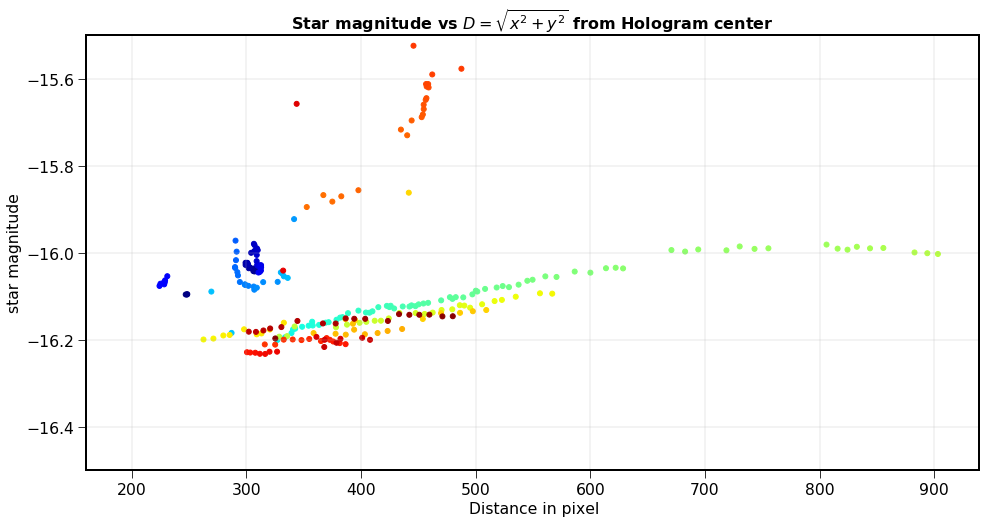

In [31]:
plt.figure(figsize=(16,8))
plt.scatter(np.sqrt((t["x0"]-180.)**2+(t["y0"]-160)**2),t["starmag"],marker="o",c=new_all_colors)
plt.grid()
#plt.ylim(-16.25,-15.9)
plt.xlabel(" Distance in pixel")
plt.ylabel("star magnitude")
plt.ylim(-16.5,-15.5)
plt.title("Star magnitude vs $D=\\sqrt{x^2+y^2}$ from Hologram center")

## Star magnitude vs airmass

Text(0.5, 1.0, 'Star magnitude vs airmass')

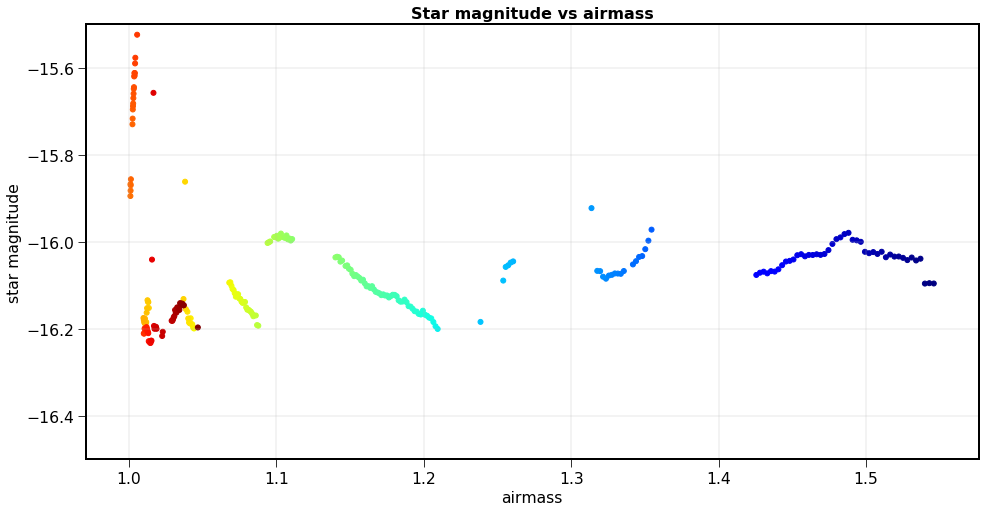

In [32]:
fig = plt.figure(num=ifig, figsize=(16, 8))
plt.scatter(t["airmass"],t["starmag"],marker="o",c=new_all_colors)
plt.grid()
#plt.ylim(-16.25,-15.9)
plt.xlabel("airmass")
plt.ylabel("star magnitude")
plt.ylim(-16.5,-15.5)
plt.title("Star magnitude vs airmass")

## Selection (x0,y0) 

In [33]:
#selected_idx=np.where(np.logical_and(t["starmag"]<-16.05,t["starmag"]>-16.06))[0]
selected_idx=np.where(np.logical_and(t["y0"]>48,t["y0"]<50.))[0]

In [34]:
selected_idx

array([ 35,  36,  37,  70, 219])

In [35]:
t["date"][selected_idx]

2019-02-15T23:16:25.487
2019-02-15T23:17:00.777
2019-02-15T23:17:36.052
2019-02-16T00:28:00.260
2019-02-16T04:26:11.666


In [36]:
t["file"][selected_idx]

T1M_20190215_231625_487_HD116405_Filtre_None_bin1x1.36_red_spectrum.fits
T1M_20190215_231700_777_HD116405_Filtre_None_bin1x1.37_red_spectrum.fits
T1M_20190215_231736_052_HD116405_Filtre_None_bin1x1.38_red_spectrum.fits
T1M_20190216_002800_260_HD116405_Filtre_None_bin1x1.23_red_spectrum.fits
T1M_20190216_042611_666_HD116405_Filtre_None_bin1x1.377_red_spectrum.fits


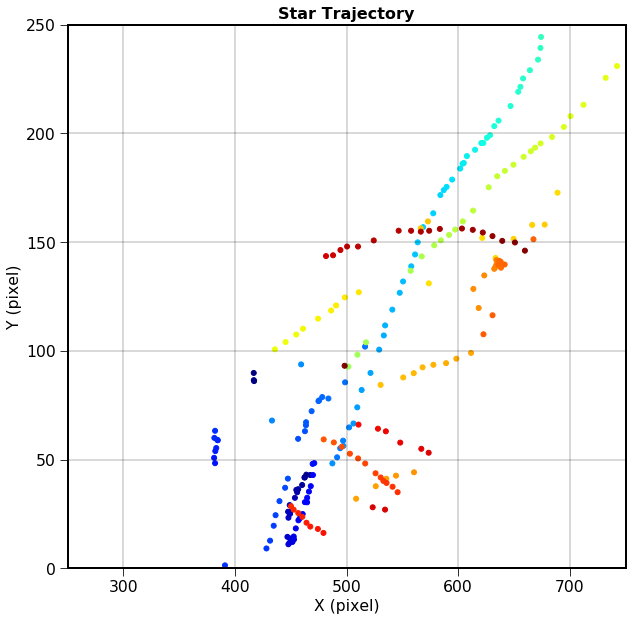

In [37]:
PlotXY(ifig,t["x0"],t["y0"],XMIN=250,XMAX=750,YMIN=0,YMAX=250)

## Selection of star position in a narrow region

In [38]:
XMIN=450
XMAX=550
YMIN=0
YMAX=100

In [39]:
theX=t["x0"].data
theY=t["y0"].data
themag=t["starmag"].data
themagerr=t["starmagerr"].data
thedate=t["date"].data
theairmass=t["airmass"].data

In [40]:
Selected_Indexes=np.where(np.logical_and(np.logical_and(theX>XMIN,theX<XMAX),np.logical_and(theY>YMIN,theY<YMAX)))[0]

In [41]:
Selected_Indexes

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  19,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  64,  65,  66,  67,
        69,  70,  71,  72,  73,  74,  75, 141, 142, 184, 192, 193, 194,
       195, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 240,
       241, 260])

In [42]:
N=len(Selected_Indexes)

In [43]:
N

80

In [44]:
#jet = plt.get_cmap('jet')
#cNorm = colors.Normalize(vmin=0, vmax=N)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [45]:
newX=theX[Selected_Indexes]
newY=theY[Selected_Indexes]
newmag=themag[Selected_Indexes]
newmagerr=themagerr[Selected_Indexes]
newdate=thedate[Selected_Indexes]
newairmass=theairmass[Selected_Indexes]
sel_colors=new_all_colors[Selected_Indexes]

In [46]:
new_datetime = [Time(d,format='isot', scale='utc').to_datetime()  for d in newdate]

### Selected trajectory

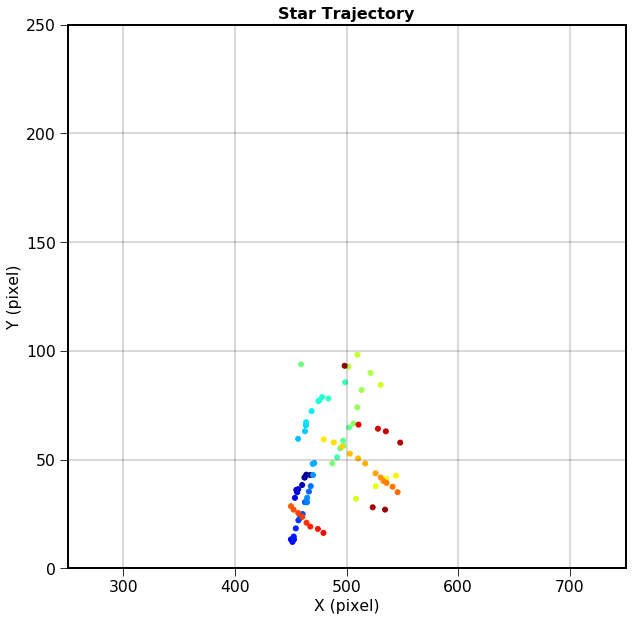

In [47]:
PlotXY(ifig,newX,newY,XMIN=250,XMAX=750,YMIN=0,YMAX=250)

### Magnitude distribution

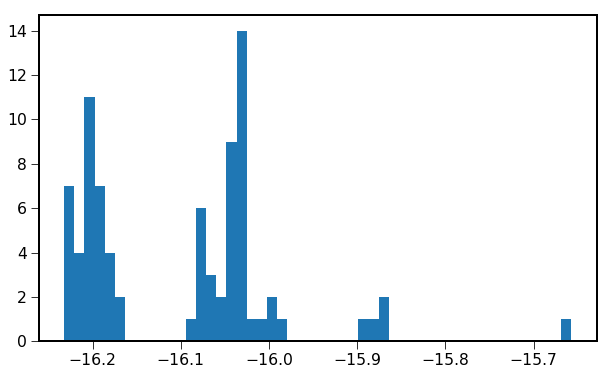

In [48]:
plt.figure(figsize=(10,6))
plt.hist(newmag,bins=50);

Text(0.5, 1.0, 'Star Magnitude vs X')

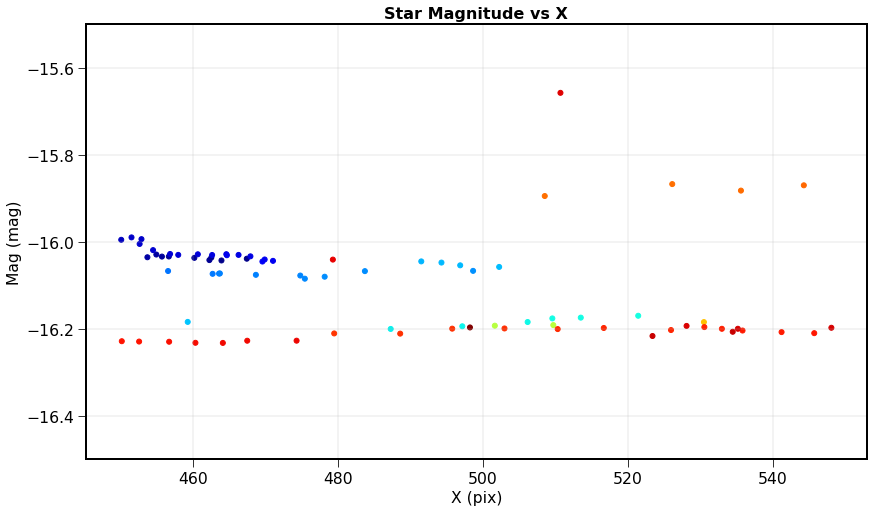

In [49]:
fig = plt.figure(num=ifig, figsize=(14, 8))
plt.scatter(newX,newmag,marker="o",c=sel_colors)
#plt.xlim(0,100)
plt.xlabel("X (pix)")
plt.ylabel("Mag (mag)")
plt.grid()
plt.ylim(-16.5,-15.5)
plt.title("Star Magnitude vs X")

Text(0.5, 1.0, 'Star Magnitude vs Y')

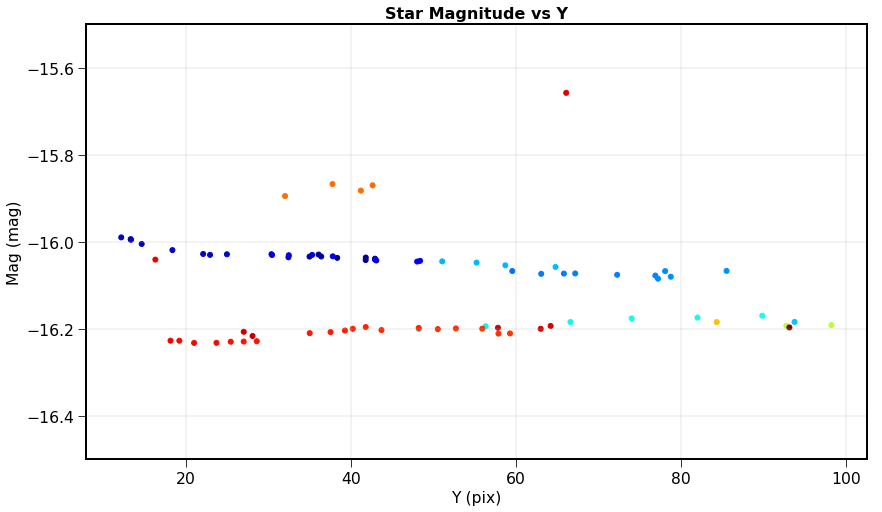

In [50]:
fig = plt.figure(num=ifig, figsize=(14, 8))
plt.scatter(newY,newmag,marker="o",c=sel_colors)
plt.xlabel("Y (pix)")
plt.ylabel("Mag (mag)")
plt.grid()
plt.ylim(-16.5,-15.5)
plt.title("Star Magnitude vs Y")

Text(0.5, 1.0, 'Star magnitude vs airmass')

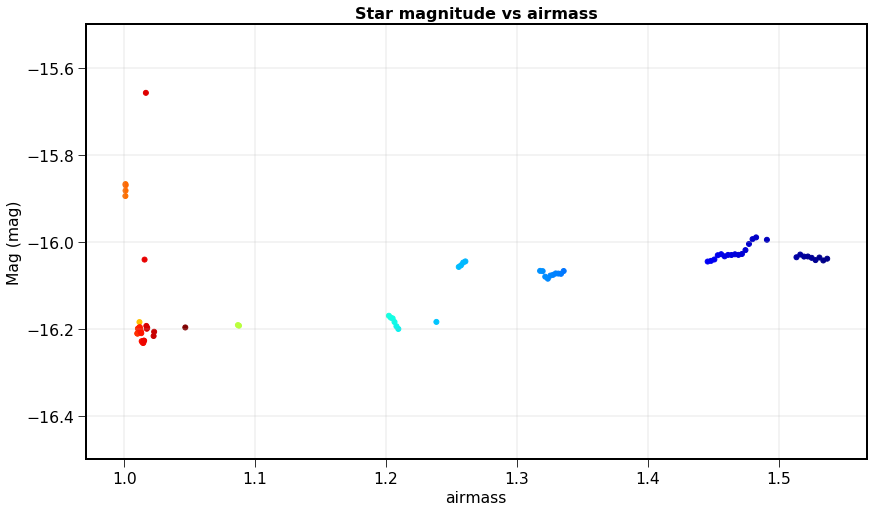

In [51]:
fig = plt.figure(num=ifig, figsize=(14, 8))
plt.scatter(newairmass,newmag,marker="o",c=sel_colors)
plt.xlabel("airmass")
plt.ylabel("Mag (mag)")
plt.grid()
plt.ylim(-16.5,-15.5)
plt.title("Star magnitude vs airmass")

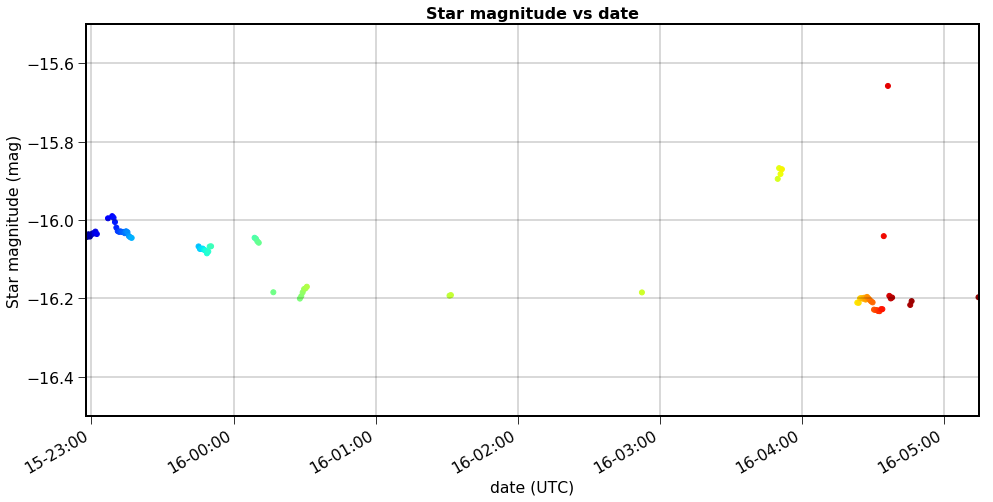

In [52]:
PlotStarmagvsUTC(ifig,new_datetime,newmag,newmagerr,YMIN=-16.5,YMAX=-15.5)